In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "Exploration"

data_path = "../data/Murdock1962.csv"
results_path = "results/"
trial_query = "`list length` == 40"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Classic_CMR_Alpha", "compmemlearn.models.Instance_CMR_Alpha", "compmemlearn.models.Classic_CMR_Alpha", "compmemlearn.models.Classic_CMR_Alpha",]

model_names = ["Prototype CMR", "InstanceCMR", "PCMR New Alpha", "ICMR New Alpha", "PCMR Broad Alpha", "PCMR Inside Alpha"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
            [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 10],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
            [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
         {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
             {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
             {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
         {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
from compmemlearn.datasets import events_metadata, generate_trial_mask

def simulate_df_from_events(model_class, parameters, events, trial_query, experiment_count, first_recall_item=None):
    """
    Initialize a model with specified parameters and experience sequences and 
    then populate a psifr-formatted dataframe with the outcomes of performing `free recall`. 
    
    **Required model attributes**:
    - item_count: specifies number of items encoded into memory
    - context: vector representing an internal contextual state
    - experience: adding a new trace to the memory model
    - free_recall: function that freely recalls a given number of items or until recall stops
    """

    trials, list_lengths, presentations = events_metadata(events)
    trial_mask = generate_trial_mask(events, trial_query)

    # confirm that only one list length was selected for this events df and trial_query
    trials = [
            trials[i][trial_mask[i]]
            for i in range(len(trials))
            if len(trials[i][trial_mask[i]]) > 0
        ]
    list_lengths = [list_lengths[i] for i in range(len(list_lengths)) if len(trials[i]) > 0]
    presentations = [presentations[i][trial_mask[i]] for i in range(len(presentations)) if len(trials[i]) > 0]
    assert(len(list_lengths) == 1)
    trials = trials[0]
    list_lengths = list_lengths[0]
    presentations = presentations[0]

    factors = []
    for column_name in events.columns[9:]:
        factors.append(
            events.pivot_table(index=['subject', 'list'], values=column_name, dropna=False).to_numpy()[trial_mask])
        assert(len(factors[-1]) == len(trials))

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    data = []
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            for presentation_index, presentation_event in enumerate(presentation):
                data.append([
                    experiment, trial_index, 'study', presentation_index+1, presentation_event, presentation_index+1
                        ])
                for factor in factors:
                    data[-1].append(factor[presentation_index])
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            if first_recall_item is not None:
                model.force_recall(first_recall_item)
            recalled = model.free_recall()
            trial = [find_first(recalled[i], presentation) + 1 for i in range(len(recalled))]

            for recall_index, recall_event in enumerate(trial):
                if recall_event != 0:
                    data.append([
                        experiment, trial_index, 'recall', recall_index+1, presentation[recall_event-1], recall_event
                            ])
                    for factor in factors:
                        data[-1].append(factor[presentation_index])
    
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'] + events.columns[9:])
    merged = fr.merge_free_recall(data)
    return merged

simulate_data = simulate_df

In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, 'subject == 1'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x0000018FF8669700>
4732.215174454715
7073.544093722985
<function murdock_objective_function.<locals>.objective_function at 0x0000018FF917C670>
4732.215174454715
7073.544093722985
<function murdock_objective_function.<locals>.objective_function at 0x0000018FF93E8790>
4732.215174454715
7073.544093722985
<function murdock_objective_function.<locals>.objective_function at 0x0000018FF991B8B0>
4732.215174454716
7073.544093722985
<function murdock_objective_function.<locals>.objective_function at 0x0000018F806F9280>
4732.215174454715
7073.544093722985
<function murdock_objective_function.<locals>.objective_function at 0x0000018FF917C670>
4732.215174454715
7073.544093722985
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for Prototype CMR with tag Exploration already exist
individual fits for InstanceCMR with tag Exploration already exist
individual fits for PCMR New Alpha with tag Exploration already exist
individual fits for ICMR New Alpha with tag Exploration already exist
individual fits for PCMR Broad Alpha with tag Exploration already exist
PCMR Inside Alpha, Subject 1
1447.0252315444989
PCMR Inside Alpha, Subject 2
2270.6268468277117
PCMR Inside Alpha, Subject 3
2177.7068948266087
PCMR Inside Alpha, Subject 4
1636.9550122410358
PCMR Inside Alpha, Subject 5
2082.4945872744242
PCMR Inside Alpha, Subject 6
1720.2556818917105
PCMR Inside Alpha, Subject 7
2293.894722361994
PCMR Inside Alpha, Subject 8
2086.257442413205
PCMR Inside Alpha, Subject 9
1704.1698252228075
PCMR Inside Alpha, Subject 10
2071.2054267911067
PCMR Inside Alpha, Subject 11
1809.0937892468512
PCMR Inside Alpha, Subject 12
1814.8932426015438
PCMR Inside Alpha, Subject 13
1925.3530858498646
PCMR Inside Alpha, Subject

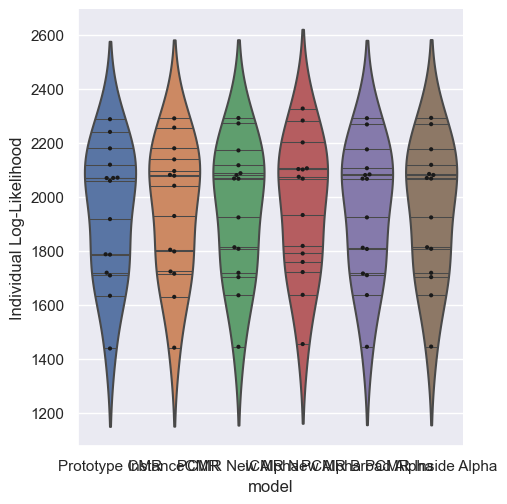

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-Explorationfits layout-nrow=2 layout-valign="center"}

![](results/individual_Exploration.pdf)

|       |   ICMR New Alpha |   InstanceCMR |   PCMR Broad Alpha |   PCMR Inside Alpha |   PCMR New Alpha |   Prototype CMR |
|:------|-----------------:|--------------:|-------------------:|--------------------:|-----------------:|----------------:|
| count |           15     |        15     |             15     |              15     |           15     |          15     |
| mean  |         1959.9   |      1948.36  |           1947.41  |            1948.61  |         1948.32  |        1940.68  |
| std   |          252.086 |       249.811 |            248.018 |             249.244 |          249.213 |         247.931 |
| min   |         1456.31  |      1443     |           1446.24  |            1447.03  |         1446.24  |        1439.98  |
| 25%   |         1776.05  |      1762.21  |           1763.15  |            1764.67  |         1764.69  |        1754.13  |
| 50%   |         2

In [7]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('Prototype CMR', 'InstanceCMR')
Ttest_relResult(statistic=-2.0967884899490974, pvalue=0.054656852121176804)
Ttest_relResult(statistic=-2.0967884899490974, pvalue=0.027328426060588402)
Ttest_relResult(statistic=-2.0967884899490974, pvalue=0.9726715739394116)

('Prototype CMR', 'PCMR New Alpha')
Ttest_relResult(statistic=-2.2568485607937108, pvalue=0.040526949357049404)
Ttest_relResult(statistic=-2.2568485607937108, pvalue=0.020263474678524702)
Ttest_relResult(statistic=-2.2568485607937108, pvalue=0.9797365253214753)

('Prototype CMR', 'ICMR New Alpha')
Ttest_relResult(statistic=-4.398777389627393, pvalue=0.0006062389737640402)
Ttest_relResult(statistic=-4.398777389627393, pvalue=0.0003031194868820201)
Ttest_relResult(statistic=-4.398777389627393, pvalue=0.999696880513118)

('Prototype CMR', 'PCMR Broad Alpha')
Ttest_relResult(statistic=-2.114998553270417, pvalue=0.05284471046608875)
Ttest_relResult(statistic=-2.114998553270417, pvalue=0.026422355233044374)
Ttest_relResult(statistic=-2.

UndefinedVariableError: name 'list_length' is not defined

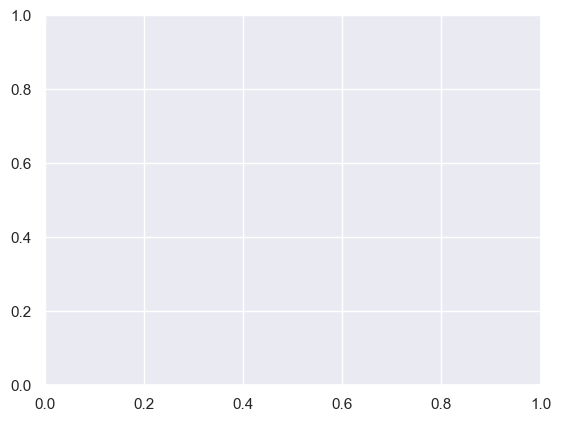

In [8]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")